In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from utility.process import convert_ed
from utility.gen_dataset import gen_dataset

# Data Processing

- Need to generate 10 different response curves from kaustubh's simulation
- Store parameters in panda table

In [57]:
# original function
def get_true_quantile(r_true, quantile=0.5):
    i = np.arange(len(r_true))
    c = np.cumsum(r_true)
    q = np.searchsorted(c, quantile*c[-1])
    return np.where(c[q]/c[-1] == quantile, 0.5 * (i[q] + i[q+1]), i[q])

# wrapper function for getting all true edh bins
def get_all_true_quantlies(r_true, quantiles):
    bins = []
    for qnt in quantiles:
        bins.append(get_true_quantile(r_true, quantile=qnt))
    return bins

In [5]:
# test above
def oracle_edh(tr, n_edh):
    bins = tr.shape[-1]
    tr_cs = np.cumsum(tr)
    tr_sum = np.sum(tr)
    edh_bins = np.zeros((n_edh-1))
    for idx in range(edh_bins.shape[-1]):
        edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))
    return edh_bins+1

# bins, trs = gen_dataset(bins=16)
# oracle_bins = oracle_edh(trs, 16)
# quantiles = []
# for idx, bd in enumerate(bins):
#     quantiles.append(np.sum(trs[:int(bd)])/np.sum(trs)*100)
# quantile_bins = get_all_true_quantlies(trs, quantiles)
# print(oracle_bins-quantile_bins)

In [18]:
# generate gaussian and return necessary parameters
def gen_gauss(a, b, c, x_range):
    return a*np.exp(-(x_range - b)**2 / (2*c**2))

def get_true_gauss_params(height, width, ambient, depth, bins):
    gauss = gen_gauss(height, depth, width/2.355, np.arange(1000)) + ambient
    return {
        'height': height,
        'width': width,
        'ambient': ambient,
        'depth': depth,
        'edh_bds': oracle_edh(gauss, bins),
        'data_pts': gauss
    }

In [40]:
# generate 10 raw gaussian datasets w/ boundaries
# store a ground-truth and blind copy to a *.pkl file

# constants
BINS = 16
HEIGHT_RANGE = (10, 100)
PULSE_WIDTH_RANGE = (10, 50)
AMBIENT_RANGE = (10, 100)
DEPTH_RANGE = (50, 950)

SAMPLE_COUNT = 10

# generation code
rng = np.random.default_rng()
data = []
for i in range(SAMPLE_COUNT):
    height = rng.uniform(low=HEIGHT_RANGE[0], high=HEIGHT_RANGE[1])
    width = rng.uniform(low=PULSE_WIDTH_RANGE[0], high=PULSE_WIDTH_RANGE[1])
    ambient = rng.uniform(low=AMBIENT_RANGE[0], high=AMBIENT_RANGE[1])
    depth = rng.uniform(low=DEPTH_RANGE[0], high=DEPTH_RANGE[1])
    data.append(get_true_gauss_params(height, width, ambient, depth, BINS))
df = pd.DataFrame(data)
df.to_pickle('data/ground-truth.pkl')
df

,height,width,ambient,depth,edh_bds,data_pts
0,50.032301,35.230387,45.511223,486.434447,"[65.0, 130.0, 195.0, 260.0, 325.0, 390.0, 455....","[45.51122328505501, 45.51122328505501, 45.5112..."
1,45.293515,45.120491,36.899388,403.783955,"[66.0, 132.0, 199.0, 265.0, 331.0, 387.0, 418....","[36.89938802951785, 36.89938802951785, 36.8993..."
2,89.617137,41.715003,64.664237,440.515485,"[66.0, 133.0, 199.0, 265.0, 332.0, 398.0, 438....","[64.66423650128571, 64.66423650128571, 64.6642..."
3,47.499843,48.529193,27.296775,792.100519,"[68.0, 136.0, 204.0, 272.0, 341.0, 409.0, 477....","[27.296774804126926, 27.296774804126926, 27.29..."
4,28.473384,28.226219,95.035155,65.328215,"[60.0, 117.0, 180.0, 243.0, 306.0, 369.0, 432....","[95.03516488426064, 95.03517063168427, 95.0351..."
5,60.777440,23.826149,84.444829,308.781899,"[64.0, 127.0, 191.0, 255.0, 309.0, 364.0, 427....","[84.44482866311405, 84.44482866311405, 84.4448..."
6,21.012299,11.617674,24.834887,193.043178,"[63.0, 126.0, 188.0, 242.0, 305.0, 368.0, 432....","[24.83488703838868, 24.83488703838868, 24.8348..."
7,96.840944,21.186996,43.420758,57.378964,"[52.0, 81.0, 147.0, 212.0, 278.0, 344.0, 409.0...","[43.42075808296785, 43.42075822799937, 43.4207..."
8,21.347335,30.711801,65.670086,238.855445,"[63.0, 126.0, 189.0, 245.0, 305.0, 368.0, 432....","[65.67008553677866, 65.67008553677866, 65.6700..."
9,56.880677,17.233557,86.524892,438.004049,"[63.0, 127.0, 190.0, 253.0, 316.0, 380.0, 437....","[86.52489227473563, 86.52489227473563, 86.5248..."


### Figure out why `plot_eqbins` doesn't work

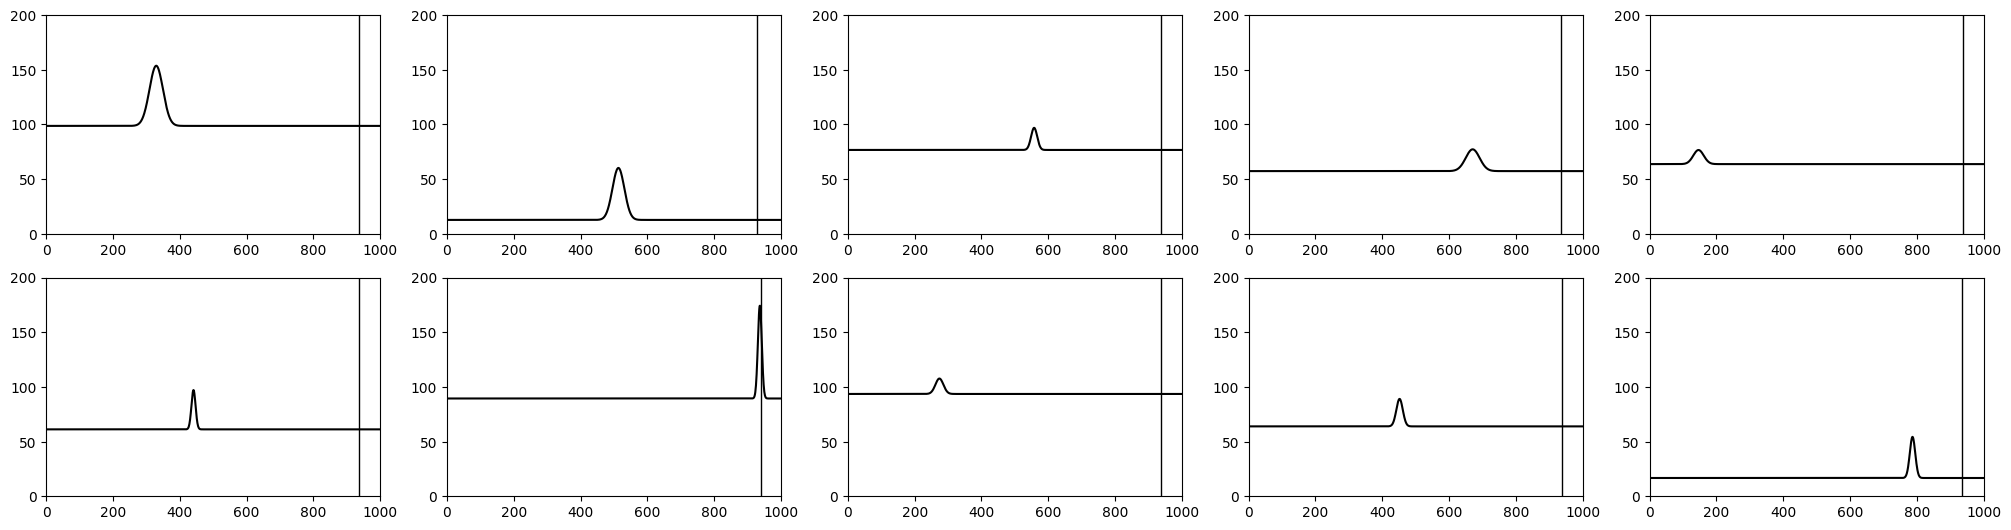

In [36]:
# functions for plotting
df = pd.read_pickle('data/ground-truth.pkl')
def binlvl(idx,len_):
    return int(math.log(len_+1,2) - math.log(math.gcd(idx+1, len_+1),2)) - 1

def plot_eqbins(ebins, ax_, lw = 1, ls='-', cmin = 0, cmax = -1):
    colors = ['r','g','b','k','y','c']
    for idx,e in enumerate(ebins):
        if (cmax!= -1) and ((e < cmin) or (e > cmax)):
            continue
    c = colors[binlvl(idx,len(ebins))]
    ax_.axvline(x = e, color = c, label = 'axvline - full height', linewidth = lw, linestyle=ls)

def plot_gaussian(x, y, edh_bins, ax):
    ax.plot(x, y, 'k-')
    plot_eqbins(edh_bins, ax)

gauss_data_set, edh_bin_set = df.data_pts, df.edh_bds
fig, axes = plt.subplots(2, 5, figsize=(25, 6.25))
for i in range(df.shape[0]):
    y_set, edh_bins = gauss_data_set[i], edh_bin_set[i]
    r, c = i % 2, i % 5
    ax = axes[r][c]
    ax.set_ylim(0, HEIGHT_RANGE[1]+100)
    ax.set_xlim(0, DEPTH_RANGE[1]+50)
    plot_gaussian(np.arange(len(y_set)), y_set, edh_bins, ax)
plt.show()

# Data Analysis

New (simpler) plan:
- generate a single ground-truth gaussian with a good spread between bin boundaries and store params
- implement a function that:
    - uses basic regression to generate a gaussian from these params
    - computes new bin boundaries with this gaussian
    - returns the sum squared difference between the original and
      generated boundaries
- use nelder mead minimize to minimize the function
- assume offset and peak width are known constants

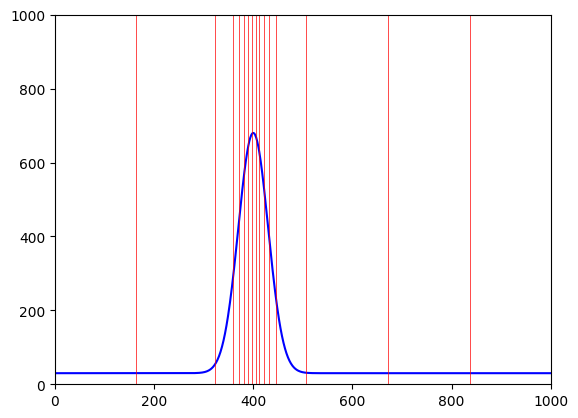

In [4]:
# generate true gaussian
def gen_gauss(x, h, d, w, o):
    return h * np.exp(-(x - d)**2 / (2 * w**2)) + o

# generate edh bin boundaries
def oracle_edh(tr, n_edh):
    bins = tr.shape[-1]
    tr_cs = np.cumsum(tr)
    tr_sum = np.sum(tr)
    edh_bins = np.zeros((n_edh-1))
    for idx in range(edh_bins.shape[-1]):
        edh_bins[idx] = np.argmin(np.abs(tr_cs - tr_sum*(idx+1.0)/n_edh))
    return edh_bins+1

# plot edh bins
def plot_edh_bins(bins, ax):
    for _bin in bins:
        ax.axvline(x=_bin, color='r', linewidth=.5)

h = 650 # peak height
d = 400 # peak offset
w = 30 # peak width
o = 30 # ambient offset

BINS = 16 # number of edh bins
X = np.arange(1000) # length of x axis (laser resolution)

gauss = gen_gauss(X, h, d, w, o)
edh_bins = oracle_edh(gauss, BINS)
                      
fig, ax = plt.subplots()
ax.set_ylim(0, len(X))
ax.set_xlim(0, len(X))
ax.plot(X, gauss, color='b')
plot_edh_bins(edh_bins, ax)
plt.show()

### `curve_fit` from scipy.optimize

- needs predicted values for all parameters in order to function
- also needs bounds in order to fit properly
- can fit a gaussian rather accurately

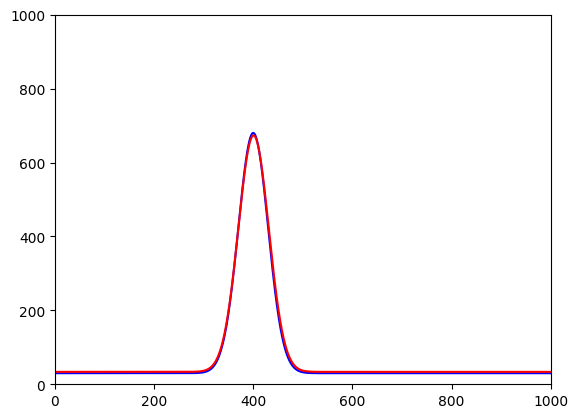

In [5]:
from scipy.optimize import curve_fit
pred_x, pred_y = convert_ed(edh_bins, edh_bins, len(X), o)
p0 = (max(pred_y), len(X)/2, w, o)
bounds = (0, len(X))
params, covars = curve_fit(gen_gauss, pred_x, pred_y, p0=p0, bounds=bounds)
_h, _d, _w, _o = params
fig, ax = plt.subplots()
ax.set_ylim(0, len(X))
ax.set_xlim(0, len(X))
ax.plot(X, gauss, color='b')
ax.plot(X, gen_gauss(X, _h, _d, _w, _o), color='r')
plt.show()

In [13]:
new_edh_bins = oracle_edh(gen_gauss(X, _h, _d, _w, _o), BINS)
for i in range(BINS-1):
    print(f'{edh_bins[i]} | {new_edh_bins[i]}')

164.0 | 154.0
322.0 | 307.0
359.0 | 356.0
372.0 | 371.0
382.0 | 382.0
390.0 | 390.0
398.0 | 398.0
405.0 | 406.0
412.0 | 414.0
421.0 | 423.0
431.0 | 434.0
446.0 | 453.0
507.0 | 538.0
671.0 | 692.0
836.0 | 846.0


In [15]:
# write the actual function
def curve_fit_ssd(bins, model, res, w, o):
    pred_x, pred_y = convert_ed(bins, bins, len(X), o)
    h, d, w, o = curve_fit(model, pred_x, pred_y, p0=(max(pred_y), len(res)/2, w, o), bounds=(0, len(res)))
    pred_bins = oracle_edh(model(res, h, d, w, o), BINS)
    return np.sum((pred_bins - bins)**2)

### nelder mead minimization

In [18]:
from scipy.optimize import minimize
res = minimize(gen_gauss, pred_x, args=(_h, _d, _w, _o), method='nelder-mead')

ValueError: The user-provided objective function must return a scalar value.